
=== AUDCAD ===
 Level  Buy  Sell  Total
     1  121   116    237
     2   35    32     67
     3   10     9     19
     4    3     3      6
     5    1     3      4
     6    0     1      1


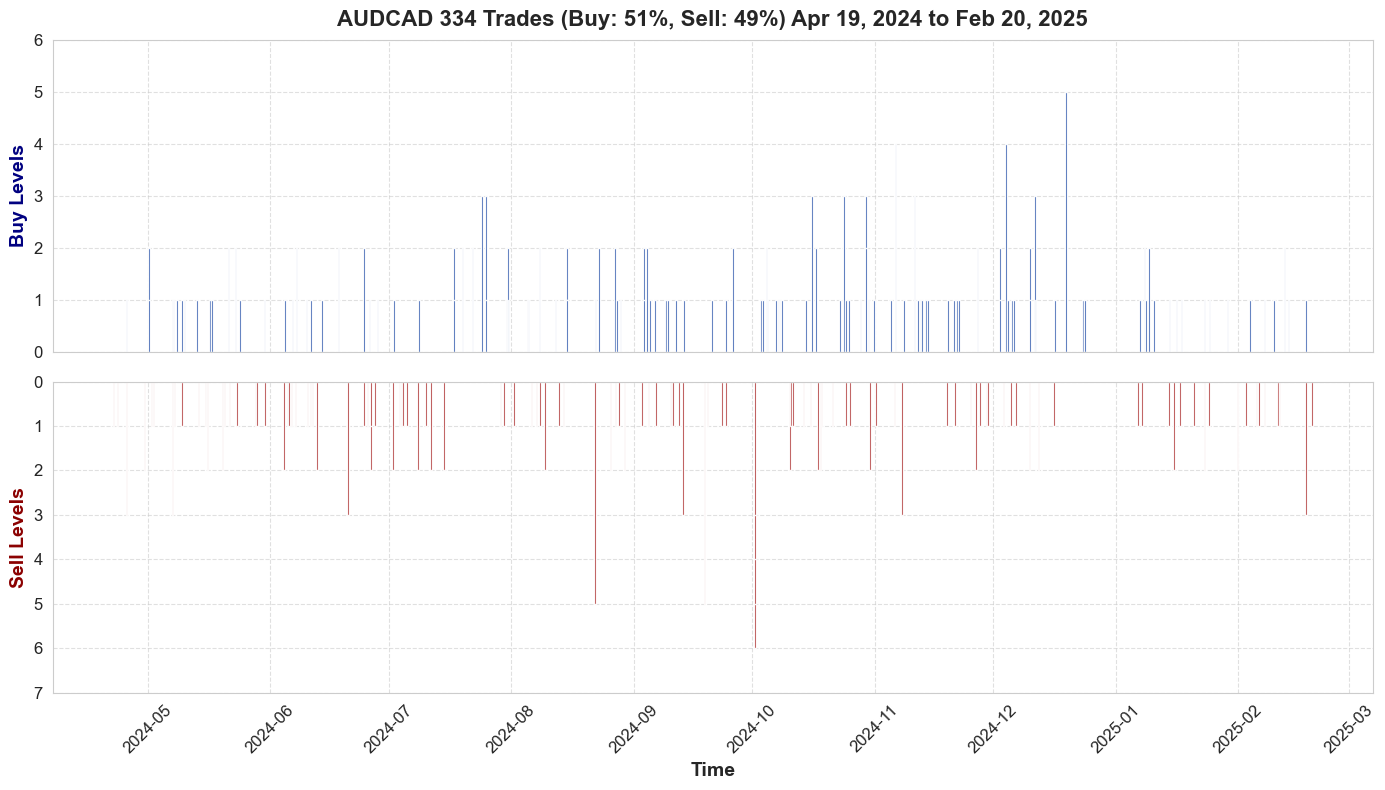


=== AUDCHF ===
 Level  Buy  Sell  Total
     1   91    66    157
     2   27    16     43
     3   10     6     16
     4    2     2      4
     5    1     2      3
     6    1     2      3
     7    1     1      2
     8    1     1      2
     9    1     1      2
    10    1     0      1
    11    1     0      1
    12    1     0      1


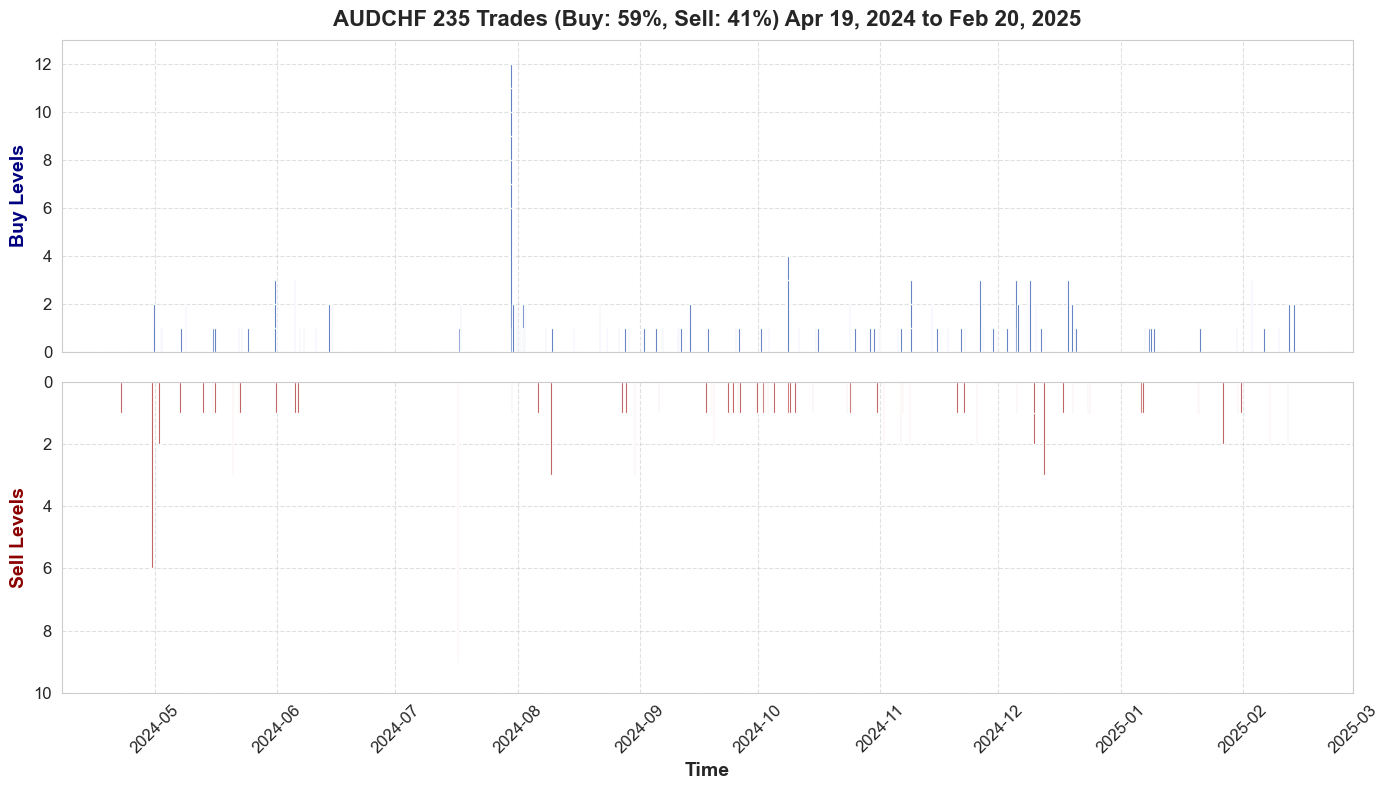


=== AUDNZD ===
 Level  Buy  Sell  Total
     1  102   106    208
     2   20    28     48
     3   10     8     18
     4    2     2      4
     5    1     1      2
     6    1     1      2
     7    1     0      1
     8    1     0      1


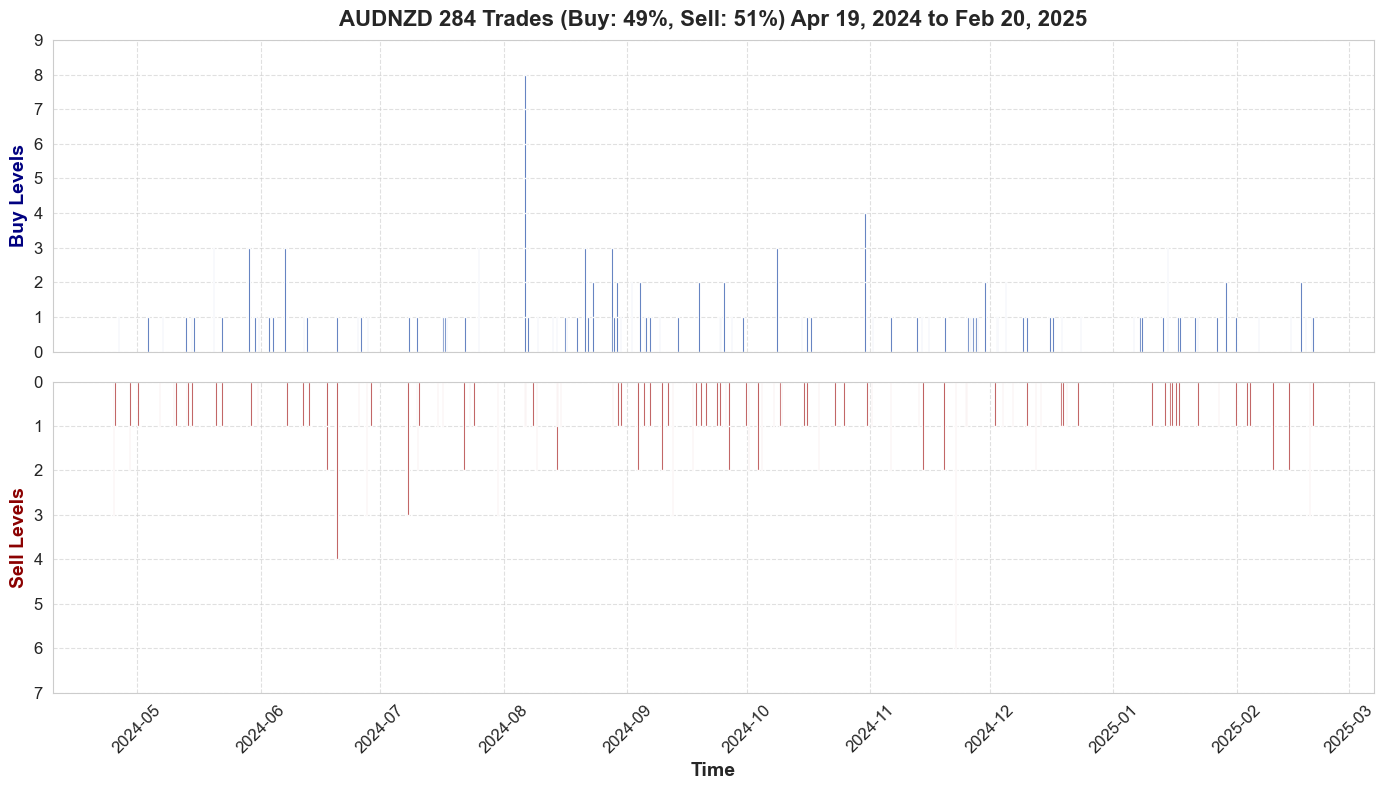


=== AUDUSD ===
 Level  Buy  Sell  Total
     1  115   102    217
     2   27    28     55
     3   10     5     15
     4    3     2      5
     5    2     1      3
     6    2     1      3
     7    1     1      2
     8    1     0      1
     9    1     0      1
    10    1     0      1
    11    1     0      1
    12    1     0      1


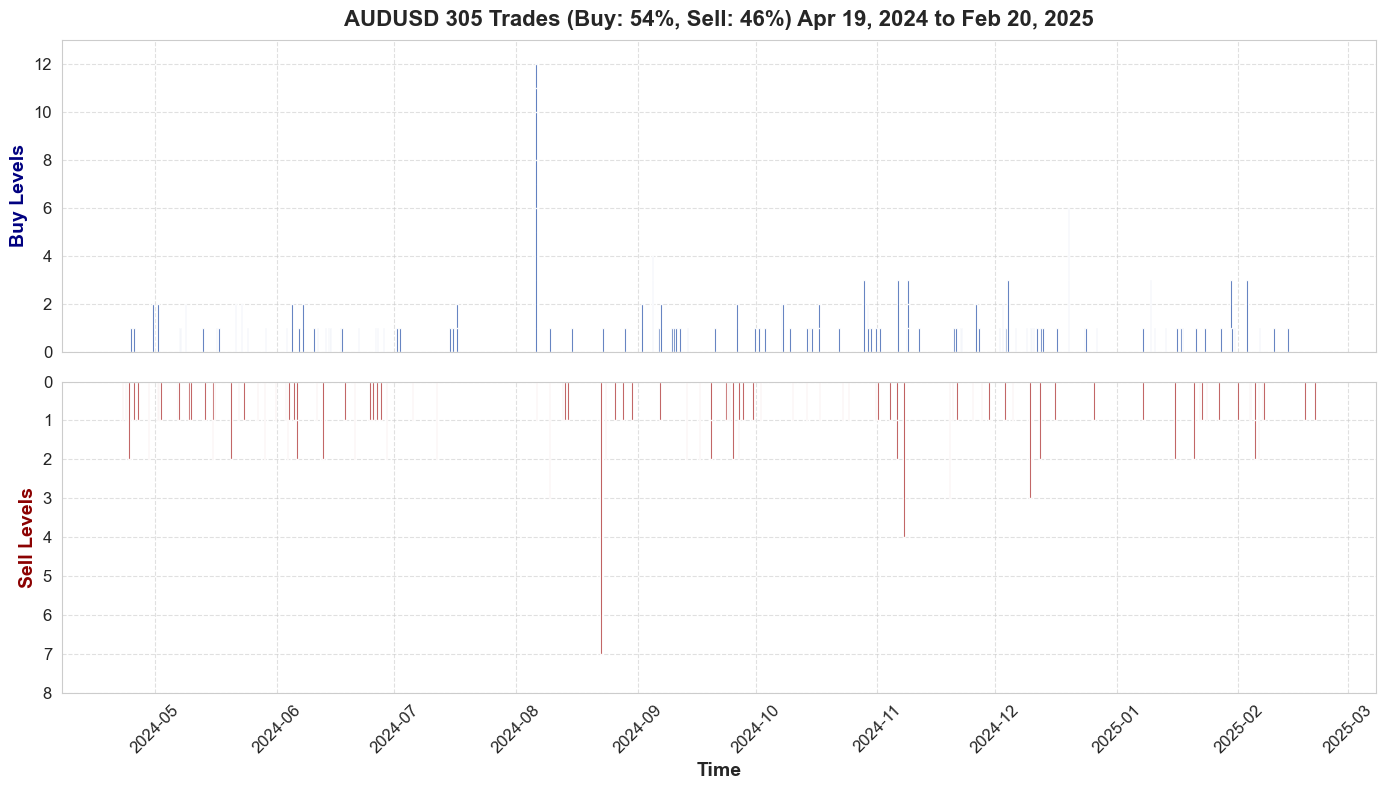


=== CADCHF ===
 Level  Buy  Sell  Total
     1   68    70    138
     2   23    20     43
     3    8     6     14
     4    4     2      6
     5    3     1      4
     6    2     1      3
     7    2     1      3
     8    1     0      1
     9    1     0      1
    10    1     0      1
    11    1     0      1
    12    1     0      1
    13    1     0      1
    14    1     0      1
    15    1     0      1
    16    1     0      1
    17    1     0      1


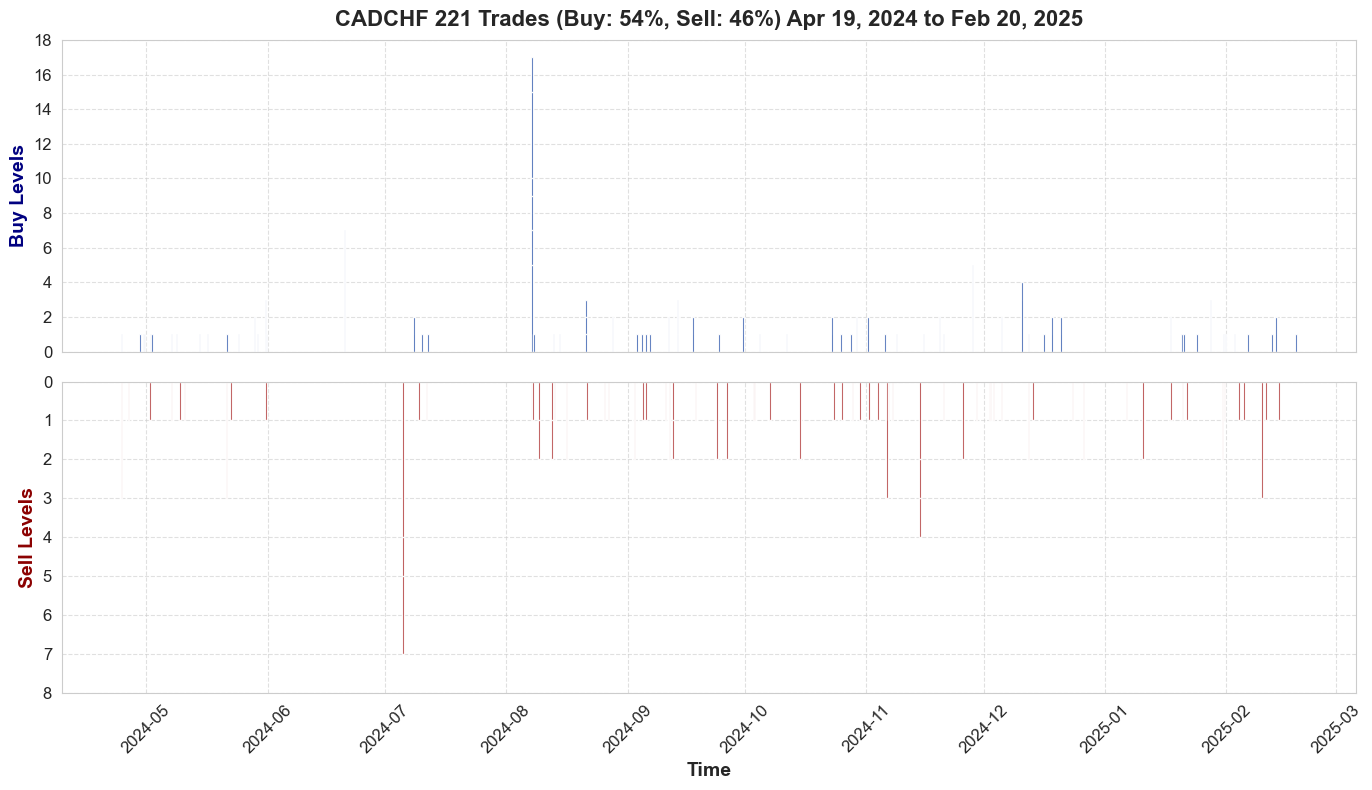


=== EURAUD ===
 Level  Buy  Sell  Total
     1  139   147    286
     2   21    22     43
     3    4     5      9
     4    0     3      3
     5    0     1      1


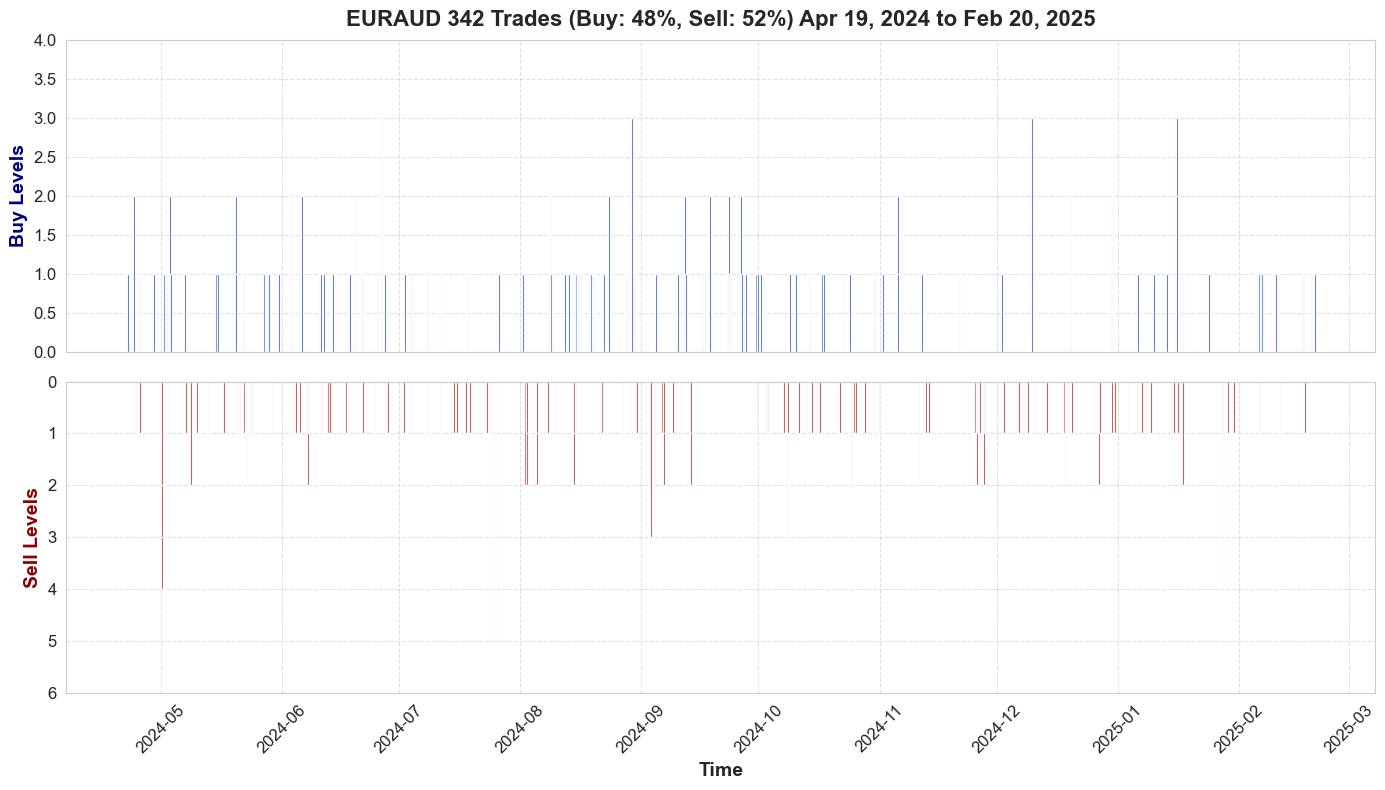


=== EURCAD ===
 Level  Buy  Sell  Total
     1  104   121    225
     2   19    27     46
     3    7     9     16
     4    3     3      6
     5    2     2      4
     6    1     2      3
     7    1     1      2


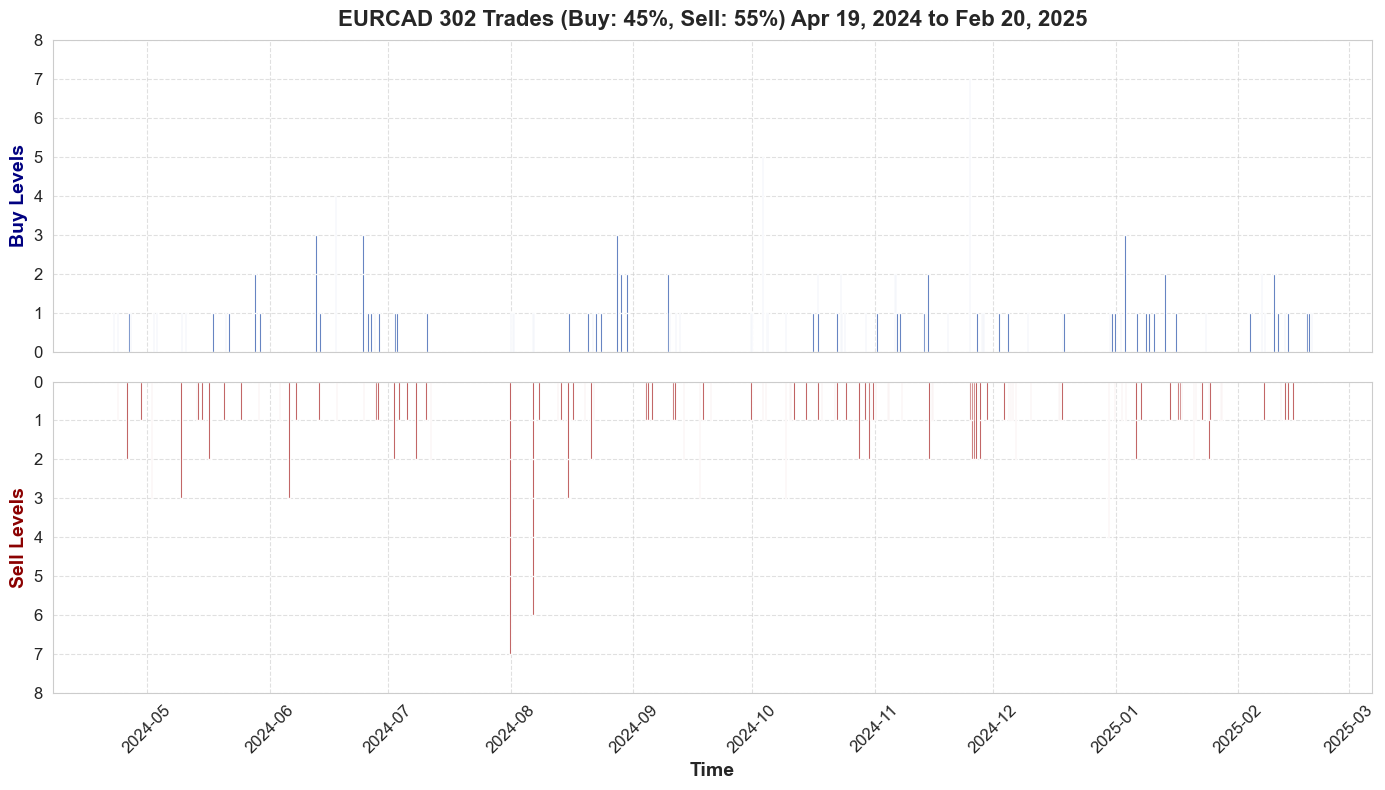


=== EURCHF ===
 Level  Buy  Sell  Total
     1  130   108    238
     2   31    29     60
     3   12     9     21
     4    6     6     12
     5    4     3      7
     6    1     1      2
     7    0     1      1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn for modern aesthetics
sns.set_style("whitegrid")

def read_and_prepare_data(filename):
    df = pd.read_excel(filename)
    df['Open Time'] = pd.to_datetime(df['Open Time'], format='%Y.%m.%d %H:%M:%S')
    df['Close Time'] = pd.to_datetime(df['Close Time'], format='%Y.%m.%d %H:%M:%S')
    return df

def determine_level(lot_size):
    if lot_size <= 0.04:
        return round(lot_size / 0.01)
    else:
        return round((lot_size - 0.4) / 0.1) + 4

def analyze_trades(df):
    results = {}
    for pair in df['Item'].unique():
        pair_df = df[df['Item'] == pair]
        buy_trades = pair_df[pair_df['Type'] == 'buy']
        sell_trades = pair_df[pair_df['Type'] == 'sell']
        
        buy_levels = {}
        sell_levels = {}
        
        for _, row in buy_trades.iterrows():
            level = determine_level(row['Size'])
            buy_levels[level] = buy_levels.get(level, 0) + 1

        for _, row in sell_trades.iterrows():
            level = determine_level(row['Size'])
            sell_levels[level] = sell_levels.get(level, 0) + 1

        levels = sorted(set(buy_levels.keys()).union(sell_levels.keys()))
        df_levels = pd.DataFrame({'Level': levels})
        df_levels['Buy'] = df_levels['Level'].map(buy_levels).fillna(0).astype(int)
        df_levels['Sell'] = df_levels['Level'].map(sell_levels).fillna(0).astype(int)
        df_levels['Total'] = df_levels['Buy'] + df_levels['Sell']

        results[pair.upper()] = {
            'df_levels': df_levels,
            'pair_df': pair_df,
            'total_trades': df_levels['Total'].sum(),
            'buy_percent': (df_levels['Buy'].sum() / df_levels['Total'].sum()) * 100,
            'sell_percent': (df_levels['Sell'].sum() / df_levels['Total'].sum()) * 100
        }
    
    return results

def plot_trade_distribution(results, pair, date_range):
    pair_data = results[pair]
    pair_df = pair_data['pair_df'].sort_values('Close Time')
    buy_trades = pair_df[pair_df['Type'] == 'buy']
    sell_trades = pair_df[pair_df['Type'] == 'sell']
    
    buy_y = [determine_level(row['Size']) for _, row in buy_trades.iterrows()]
    sell_y = [determine_level(row['Size']) for _, row in sell_trades.iterrows()]

    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

    # Define custom colors (darker navy blue and dark red)
    buy_color = (0.0, 0.2, 0.6, 0.9)  # RGBA (Dark Navy Blue with 90% opacity)
    sell_color = (0.6, 0.0, 0.0, 0.9)  # RGBA (Dark Red with 90% opacity)

    # Buy graph (positive, upwards)
    axs[0].bar(buy_trades['Close Time'], buy_y, width=0.4, color=buy_color, alpha=0.95)  # Slightly higher opacity
    axs[0].set_ylabel("Buy Levels", fontsize=14, color='navy', fontweight='bold')
    axs[0].set_title(f"{pair} {pair_data['total_trades']} Trades (Buy: {pair_data['buy_percent']:.0f}%, Sell: {pair_data['sell_percent']:.0f}%) {date_range}",
                     fontsize=16, fontweight='bold', pad=10)

    # Sell graph (positive but visually flipped downward)
    axs[1].bar(sell_trades['Close Time'], sell_y, width=0.4, color=sell_color, alpha=0.95)  # Slightly higher opacity
    axs[1].invert_yaxis()  # Flip the sell graph downward
    axs[1].set_ylabel("Sell Levels", fontsize=14, color='darkred', fontweight='bold')
    axs[1].set_xlabel("Time", fontsize=14, fontweight='bold')

    # Align Buy 0-axis to touch Sell 0-axis (eliminate space)
    axs[0].set_ylim(0, max(buy_y) + 1)
    axs[1].set_ylim(max(sell_y) + 1, 0)  # Inverted y-axis

    # Increase tick size
    axs[0].tick_params(axis='both', labelsize=12)
    axs[1].tick_params(axis='both', labelsize=12)

    # Improve grid visibility
    axs[0].grid(True, linestyle="--", alpha=1.0)
    axs[1].grid(True, linestyle="--", alpha=1.0)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def generate_trade_report(results, df):
    date_range = f"{df['Open Time'].min().strftime('%b %d, %Y')} to {df['Close Time'].max().strftime('%b %d, %Y')}"
    for pair, data in results.items():
        print(f"\n=== {pair} ===")
        print(data['df_levels'][['Level', 'Buy', 'Sell', 'Total']].to_string(index=False))
        plot_trade_distribution(results, pair, date_range)

df = read_and_prepare_data('shadowhistory.xlsx')
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')
df['Profit'].fillna(0, inplace=True)
results = analyze_trades(df)
generate_trade_report(results, df)
